In [150]:
# from meshing_utils import geometry1D as g1d
"""Cassiopee"""
# from curses import window
import Geom.PyTree as D
import Generator.PyTree as G
import Converter.PyTree as C
import Converter.Internal as I
import Converter.elsAProfile as _elsAProfile
import Transform.PyTree as T
import Connector.PyTree as X

""" Meshing utils """
from meshing_utils import logger
from meshing_utils import parser
from meshing_utils import plotting
from meshing_utils import geometry1D as geom1
from meshing_functions import *  
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline, splder
from numba import jit
from scipy.optimize import fsolve
import os
import pickle
%matplotlib widget

In [151]:
Mach = 4.5
gamma = 1.4
Re_m = 3.4e6
T_inf = 288

In [152]:
print( 8160/Re_m)

0.0024


In [153]:
workdir = ''

Rein = 8160
x0 = 8160/Re_m # = 0.0024
l = 1.75e6/Re_m #restriction of forcing and response said by Arthur but he is wrong
l = 2e6/Re_m #End domain arthur
print(l)

l_fp = l
# h_fp = 0.11
Ni = 1000
Nj = 150


# First version 
yplus_in = 0.5e-5*7
yplus_out = 1e-5*2*5
delta99_in = 0.00119
delta99_out = 0.00472
# => Time step 5e-8s RK4

#calculated nicely with bf
yplus_in = 0.5e-5*4
yplus_out = 1e-5*2*4
yplus_out = 4e-5
delta99_in = 0.00047599
delta99_out = 0.00455549 

print(f'{delta99_in = }, {delta99_out = }')

h_fp = delta99_out*9

saving = True
additional_name = 'TM_arthur_fine_y'

0.5882352941176471
delta99_in = 0.00047599, delta99_out = 0.00455549


In [154]:
import numpy as np
import Converter.Internal as I
import Converter.PyTree as C
import Post.PyTree as P
import Transform as T
import os
from scipy.interpolate import griddata

def comp_Sutherland(propref, Ts, Cs, T):
    '''Dynamical viscosity / thermal conductivity from sutherland law'''
    return propref*np.sqrt(T/Ts)*((1.+Cs/Ts)/(1.+Cs/T))
def compute_prim_bf(bf, gam=1.4, r_gas=287.15):
    
    bfp = np.zeros(bf.shape, dtype=np.float64)
    #primitives (rho u T)
    bft = np.zeros(bf.shape, dtype=np.float64)

    bfp[0] = bf[0]
    bfp[1:4] = bf[1:4]/bf[0]
    
    bft = np.copy(bfp)
    
    bfp[-1] = (gam-1.0) * (bf[-1]-0.5*(np.sum(bf[1:4]**2, axis=0))/bf[0])

    
    bft[-1] = bfp[-1] / (r_gas * bft[0])

    # T =  (gam-1.0)*(bf[-1]-0.5*(np.sum(bf[1:4]**2, axis=0))/bf[0])/(r_gas*bf[0])
    # print('bfp[-1]-T=', norm(bfp[-1]-T))
    # print('bft[-1]-T=', norm(bft[-1]-T))
    
    return bfp, bft


file_dir = "/net/jabba/home1/nd612731/Documents/mesh/mesh_flat_plate"
file = "fixedpoint_dim.cgns"
out_dir = "/net/jabba/home1/nd612731/Documents/mesh/mesh_flat_plate"

names = ["Density", "MomentumX", "MomentumY", "MomentumZ", "EnergyStagnationDensity"]


###
# Physical setup
dphys = dict()
dphys['gam']      = 1.4       # Gamma constant
dphys['Ts']       = 273.15    # Sutherland ref temp
dphys['cs']       = 110.4     # Sutherland constant (temp
dphys['musuth']   = 1.715e-5  # Sutherland ref dynamic viscosity
dphys['rgaz']     = 287.056     # Air ideal gas constant
dphys['Prandtl']  = 0.72      # Prandtl number


path_file = os.path.join(file_dir, file)
print('input:', path_file) 
t_base = C.convertFile2PyTree(path_file)



print('')

adim_in = False

if adim_in:
    ref = I.getNodeFromName(t_base, name='ReferenceState')
    Lref=I.getVal(I.getNodeFromName(ref, 'Length_ref'))
    print('Lref = ', Lref)
    Lref = 1 / I.getVal(I.getNodeFromName(ref, "Reynolds_unit"))


    rho_ref = I.getVal(I.getNodeFromName(ref, 'Density_ref'))
    mom_ref = I.getVal(I.getNodeFromName(ref, 'V_ref'))*rho_ref
    rhoE_ref = I.getVal(I.getNodeFromName(ref, 'EnergyStagnation_ref'))

else: 
    Lref=1.0
    rho_ref = 1.0
    mom_ref = 1.0
    rhoE_ref = 1.0

#
stateref= {"Density": rho_ref, "MomentumX": mom_ref, "MomentumY":mom_ref, "MomentumZ":mom_ref, "EnergyStagnationDensity": rhoE_ref}
print("stateref: ", stateref)





t_base = C.node2Center(t_base)

grid_x_in_2D = I.getValue(I.getNodeFromName(t_base, "CoordinateX"))*Lref
grid_y_in_2D = I.getValue(I.getNodeFromName(t_base, "CoordinateY"))*Lref
values_in = I.getValue(I.getNodeFromName(t_base, "Density"))*rho_ref
grid_x_in = np.reshape(grid_x_in_2D, (-1, 1), order="F")
grid_y_in = np.reshape(grid_y_in_2D, (-1, 1), order="F")
values_in = np.squeeze(np.reshape(values_in, (-1, 1), order="F"))


#Wall coordinates is x,y base
X_wall_node_in = grid_x_in_2D[:,0]
Y_wall_node_in = grid_y_in_2D[:,0]
X_wall_in = (X_wall_node_in[1:]+X_wall_node_in[:-1])/2
Y_wall_in = (Y_wall_node_in[1:]+Y_wall_node_in[:-1])/2
Rn_in = np.abs(X_wall_in[0])
print(f'{Rn_in = }')





points_in = np.transpose(np.squeeze((grid_x_in, grid_y_in)))
print(np.shape(points_in))
print(np.shape(values_in))

# output file



# points_out = (grid_x_out, grid_y_out)
# #Wall coordinates is x,y base
# X_wall_node = grid_x_out[:,0]
# Y_wall_node = grid_y_out[:,0]
# X_wall = (X_wall_node[1:]+X_wall_node[:-1])/2
# Y_wall = (Y_wall_node[1:]+Y_wall_node[:-1])/2
# Rn = np.abs(X_wall[0])
# print(f'{Rn = }')



im_in, jm_in = np.shape(grid_x_in_2D)
bf_in = np.zeros((im_in, jm_in, 5))

for i in range(5):
    bf_in[:,:,i] = I.getValue(I.getNodeFromName(t_base, names[i]))*stateref[names[i]]
bf_in = np.moveaxis(bf_in, (0,1,2), (1,2,0))
bfp_in, bft_in = compute_prim_bf(bf_in, dphys['gam'],dphys['rgaz'])

mu = comp_Sutherland(dphys['musuth'], dphys['Ts'], dphys['cs'], bft_in[4,:,:])
print('rho inf = {}, MumX inf = {}, MumY inf = {}, Estag inf = {}'.format(bf_in[0,0,-1], bf_in[1,0,-1], bf_in[2,0,-1], bf_in[4,0,-1]))
print('rho inf = {}, Vx inf = {}, Vy inf = {}, T inf = {}'.format(bft_in[0,0,-1], bft_in[1,0,-1], bft_in[2,0,-1], bft_in[4,0,-1]))

ds_j_wall_in = ((grid_x_in_2D[:, 1]-X_wall_node_in)**2+(grid_y_in_2D[:, 1]-Y_wall_node_in)**2)**(0.5)
V_in = (bft_in[1,:,:]**2+bft_in[2,:,:]**2)**0.5


tau_wall = mu[:,0]*(V_in[:,1]-0)/ds_j_wall_in
U_tau = (tau_wall/bft_in[0,:,0])**(0.5)
y_plus_1st_cell = U_tau*ds_j_wall_in*bft_in[0,:,0]/mu[:,0]

euclid_len = lambda x,y: np.sqrt(x**2+ y**2)
# dist2center = euclid_len(X_wall,Y_wall) #Calculate the distance of the wall to the origini 0=(0,0)
# insphere = np.isclose(dist2center, Rn, rtol=1e-04, atol=1e-09, equal_nan=False) #find points on the nose sphere
# i_cone_junction = np.squeeze(np.argwhere(insphere == True)[-1])
# print(f'{i_cone_junction = }')
print('\nFor input mesh')
print(f'At stagnation point \t: y+ = {y_plus_1st_cell[0]}, \tU_tau = {U_tau[0]}, \ttau_wall = {tau_wall[0]}')
# print(f'At cone junction point \t: y+ = {y_plus_1st_cell[i_cone_junction]}, \tU_tau = {U_tau[i_cone_junction]}, \ttau_wall = {tau_wall[i_cone_junction]}, {i_cone_junction = }')
print(f'At end \t\t\t: y+ = {y_plus_1st_cell[-1]}, \tU_tau = {U_tau[-1]}, \ttau_wall = {tau_wall[-1]}')




input: /net/jabba/home1/nd612731/Documents/mesh/mesh_flat_plate/fixedpoint_dim.cgns
Reading /net/jabba/home1/nd612731/Documents/mesh/mesh_flat_plate/fixedpoint_dim.cgns (bin_hdf)...done.

stateref:  {'Density': 1.0, 'MomentumX': 1.0, 'MomentumY': 1.0, 'MomentumZ': 1.0, 'EnergyStagnationDensity': 1.0}
Rn_in = 0.0006335276452923472
(137689, 2)
(137689,)
rho inf = 0.03969857449879697, MumX inf = 60.77581644331625, MumY inf = 3.250184925072888, Estag inf = 54777.57668906641
rho inf = 0.03969857449879697, Vx inf = 1530.9319594122458, Vy inf = 81.87157766008404, T inf = 285.11448876821066

For input mesh
At stagnation point 	: y+ = 0.44555570398621624, 	U_tau = 480.1860387487237, 	tau_wall = 2070.927165222265
At end 			: y+ = 0.24569006365781806, 	U_tau = 75.0968904108119, 	tau_wall = 48.67227812004789


In [167]:
#calculate CFL

a = (dphys['gam']*dphys['rgaz']*bft_in[4,:,:])**0.5
V_in = (bft_in[1,:,:]**2+bft_in[2,:,:]**2)**0.5
di_cfl = np.diff(grid_x_in_2D, axis = 0)
dj_cfl = np.diff(grid_y_in_2D, axis = 1)

CFL_i_t = (np.abs(bft_in[1,:-1,:]) + a[:-1])/di_cfl
CFL_j_t = (np.abs(bft_in[2,:,:-1]) + a[:, :-1])/dj_cfl

print(r'Argmax $CFL_i/\Delta t$', np.unravel_index(np.argmax(CFL_i_t), np.shape(di_cfl)))
print(r'Argmax $CFL_j/\Delta t$', np.unravel_index(np.argmax(CFL_j_t), np.shape(dj_cfl)))

Argmax $CFL_i/\Delta t$ (868, 82)
Argmax $CFL_j/\Delta t$ (0, 0)


In [156]:
wall = D.line([x0,0,0], [l_fp, 0,0])
top  = D.line([x0,h_fp,0], [l_fp,h_fp,0])
inlet = D.line([x0,0,0],[x0,h_fp,0])
outlet = D.line([l_fp,0,0],[l_fp,h_fp,0])

In [157]:
bp = {'N':Ni}
geom1._enforceDistribOnLine(wall,'uniform', bp1=bp)
I.setName(wall,'fp_wall')

bp = {'N':Ni}
geom1._enforceDistribOnLine(top,'uniform', bp1=bp)
I.setName(top,'fp_top')

/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 2622 in _enforceDistribOnLine


In [158]:
geom1._enforceBLdistribOnLine(inlet,yplus=yplus_in,
                              delta=delta99_in,
                              distTypeInner='linear', 
                              distTypeOuter='geom1',
                              totalNumberOfNodes=Nj,
                              innerGrowthRate=1.05,
                              outerGrowthRate=1.01)

I.setName(inlet,'inlet')


[0.00047599 0.04052342] True
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 1862 in _enforceMultiDistribOnLine
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/parser.py line 87 in _checkLog
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 2277 in _enforceBLdistribOnLine


In [159]:
# geom1._enforceBLdistribOnLine(outlet,yplus=yplus_out,
#                               delta=delta99_out,
#                               distTypeInner='linear',  #inside the BL
#                               distTypeOuter='geom1',
#                               totalNumberOfNodes=Nj,
#                               innerGrowthRate=1.01, 
#                               outerGrowthRate=1.05)

#like arthur
geom1._enforceBLdistribOnLine(outlet,yplus=yplus_out,
                              delta=delta99_out*2.8,
                              distTypeInner='geom1',  #inside the BL
                              distTypeOuter='geom1',
                              totalNumberOfNodes=200,
                              innerGrowthRate=1.01, 
                              outerGrowthRate=1.05)

print('delta99 = ', delta99_in, delta99_out)

delta99_out = delta99_in
print('delta99 = ', delta99_in, delta99_out)

geom1._enforceBLdistribOnLine(outlet,yplus=yplus_in,
                              delta=delta99_out*2.8,
                              distTypeInner='geom1',  #inside the BL
                              distTypeOuter='geom1',
                              totalNumberOfNodes=200,
                              innerGrowthRate=1.02, 
                              outerGrowthRate=1.05)

I.setName(outlet,'inlet')

[0.01275537 0.02824404] True
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 1862 in _enforceMultiDistribOnLine
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/parser.py line 87 in _checkLog
delta99 =  0.00047599 0.00455549
delta99 =  0.00047599 0.00047599
[0.00133277 0.03966664] True
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 1862 in _enforceMultiDistribOnLine
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/parser.py line 87 in _checkLog
/net/jabba/home1/nd612731/Documents/mesh/meshing_utils/geometry1D.py line 2277 in _enforceBLdistribOnLine


Argmax CFL_j/dt (2,)
max CFL/dt =  36857356.30616317
max dt (for CFL = 0.5) =  1.3565812909820436e-08
Number of nodes before end of BL :  20
Number of nodes before end of inner mesh :  43
Number of nodes before end of domain (top) :  200
y+ =  1.8014420358642735
delta y 0 =  2e-05 1.9999999999996583e-05
delta99 =  0.00047599


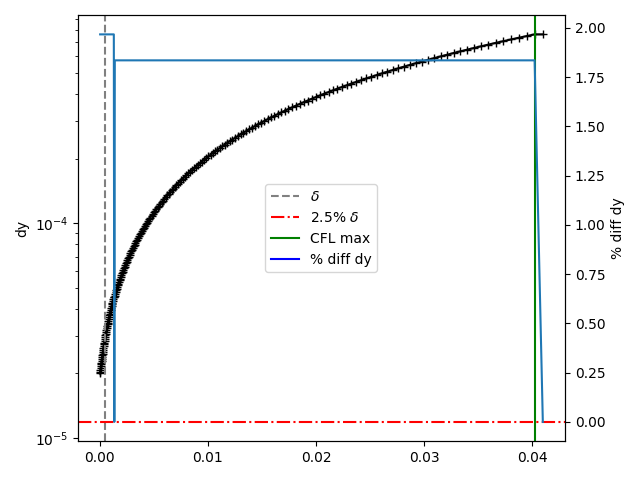

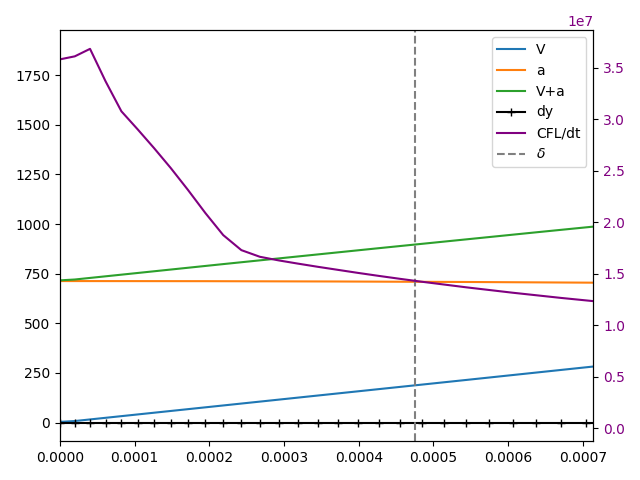

In [170]:
i_target = 0

y_test = I.getValue(I.getNodeByName(outlet, 'CoordinateY'))
dy_test = np.concatenate([np.diff(y_test), [np.diff(y_test)[-1]]])

#Calculate CFL at end of plate
a = (dphys['gam']*dphys['rgaz']*bft_in[4,:,:])**0.5
V_in = (bft_in[1,:,:]**2+bft_in[2,:,:]**2)**0.5
dj_cfl = dy_test


CFL_j_t = (np.interp(y_test[:], grid_y_in_2D[i_target],np.abs(bft_in[2,i_target])) + np.interp(y_test[:], grid_y_in_2D[i_target],a[i_target]))/dj_cfl
print('Argmax CFL_j/dt', np.unravel_index(np.argmax(CFL_j_t), np.shape(dj_cfl)))
print('max CFL/dt = ', np.max(CFL_j_t))
print('max dt (for CFL = 0.5) = ', 0.5/np.max(CFL_j_t))


fig, axe = plt.subplots()
axe2 = axe.twinx()
axe.scatter(y_test, y_test*0)
axe.plot(y_test, dy_test, color = 'k', marker = '+')


axe2.plot(y_test[1:], (dy_test[1:]-dy_test[:-1])/dy_test[:-1]*100, color = 'tab:blue')

axe.axvline(delta99_out, color = 'grey', linestyle = '--', label = r'$\delta$')
axe.axhline(2.5/100*delta99_out, color = 'r', linestyle = '-.', label = r'2.5% $\delta$')
axe.axvline(y_test[np.unravel_index(np.argmin(CFL_j_t), np.shape(dj_cfl))], color = 'g', label = 'CFL max')
axe.plot([],[], color = 'b', label = r'% diff dy')
axe.set_ylabel(r'dy')
axe2.set_ylabel(r'% diff dy')
axe.set_yscale('log')
# axe2.set_yscale('log')
axe.legend(loc = 'center')
# axe.set_xscale('log')
fig.tight_layout()

print('Number of nodes before end of BL : ', np.argmin(np.abs(y_test-delta99_out)))
print('Number of nodes before end of inner mesh : ', np.argmin(np.abs(y_test-delta99_out*2.8)))
print('Number of nodes before end of domain (top) : ', len(y_test))



fig, axe = plt.subplots()
axe2 = axe.twinx()
axe.plot(y_test, np.interp(y_test[:], grid_y_in_2D[-1],V_in[-1]), label = 'V')
axe.plot(y_test, np.interp(y_test[:], grid_y_in_2D[-1],a[-1]), label = 'a')
axe.plot(y_test, np.interp(y_test[:], grid_y_in_2D[-1],a[-1])+np.interp(y_test[:], grid_y_in_2D[-1],V_in[-1]), label = 'V+a')
axe.plot(y_test, dy_test, color = 'k', marker = '+', label = 'dy')
axe2.plot(y_test, CFL_j_t, label = 'CFL/dt', color = 'purple')
axe2.tick_params(axis='y', labelcolor= 'purple')
axe.plot([], [], label = 'CFL/dt', color = 'purple')

axe.axvline(delta99_out, color = 'grey', linestyle = '--', label = r'$\delta$')
axe.set_xlim(0, 1.5*delta99_out)
axe.legend()
fig.tight_layout()



print('y+ = ',  U_tau[i_target]*(y_test[1]-y_test[0])*bft_in[0,i_target,0]/mu[i_target,0]) #looks ounly at out
print('delta y 0 = ', yplus_in, (y_test[1]-y_test[0]))
print('delta99 = ', delta99_out)


In [ ]:
import sys, os
def silent_call(func, *args, **kwargs):
    # Save current stdout
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    try:
        return func(*args, **kwargs)
    finally:
        # Restore stdout
        sys.stdout.close()
        sys.stdout = old_stdout

In [ ]:
list_yplus =  1e-6*np.arange(1, 20)
list_yplus = np.linspace(1e-6, 1e-4, 20)
eps = 0.001
innerGrowthRates =  np.linspace(1+eps,1.1,10)
distType = 'geom1'

print('delta_99 = ', delta99_out)
print('Number of points in BL : ')
print(f'{distType = }')

j_BL_mesh_geom = np.zeros((len(list_yplus), len(innerGrowthRates)))
y_plus_1st_cell_BL_mesh_geom = np.zeros((len(list_yplus), len(innerGrowthRates)))

for i, yplusi in enumerate(list_yplus):

    for j, innerGrowthRate in enumerate(innerGrowthRates):
        try:
            outlet = D.line([l_fp,0,0],[l_fp,h_fp,0])
            # geom1._enforceBLdistribOnLine(outlet,
            #                           yplus=yplusi,
            #                           delta=delta99_out*2.8,
            #                           distTypeInner = distType,  #inside the BL
            #                           distTypeOuter='geom1',
            #                           totalNumberOfNodes=Nj,
            #                           innerGrowthRate=1.05, 
            #                           outerGrowthRate=1.10)
            
            silent_call(geom1._enforceBLdistribOnLine, outlet,
                                    yplus=yplusi,
                                    delta=delta99_out*2.8,
                                    distTypeInner = distType,  #inside the BL
                                    distTypeOuter='geom1',
                                    totalNumberOfNodes=Nj,
                                    innerGrowthRate=innerGrowthRate, 
                                    outerGrowthRate=1.10)
            y_test = I.getValue(I.getNodeByName(outlet, 'CoordinateY'))

            j_BL = np.argmin(np.abs(y_test-delta99_out))
            y_plus_1st_cell_BL_mesh_geom[i,j] = U_tau[-1]*(y_test[1]-y_test[0])*bft_in[0,-1,0]/mu[-1,0] #looks ounly at out
            j_BL_mesh_geom[i, j] = j_BL
            print(f'{i = }, {j = }, {yplusi = },{innerGrowthRate = }, {j_BL = }')
        except:
            j_BL_mesh_geom[i, j] = np.nan
            y_plus_1st_cell_BL_mesh_geom[i, j] = np.nan

In [ ]:
yplus_grid, innerGrowthRates_grid = np.meshgrid(list_yplus, innerGrowthRates)

fig, axe = plt.subplots()

# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
CS_geom = axe.pcolormesh(yplus_grid, innerGrowthRates_grid, j_BL_mesh_geom.transpose(), cmap = 'jet', vmin = 15, vmax = 130)
CS_contour = axe.contour(yplus_grid, innerGrowthRates_grid, j_BL_mesh_geom.transpose(), levels = [40, 80], colors = 'r')
axe.clabel(CS_contour, CS_contour.levels, inline=True, fmt='%.d'.replace('-',''))

CS_contour = axe.contour(yplus_grid, innerGrowthRates_grid, y_plus_1st_cell_BL_mesh_geom.transpose(), colors = 'k', linestyles = '--') 
axe.plot([], [], color = 'k', linestyle = '--', label = 'y+')
axe.clabel(CS_contour, (CS_contour.levels), inline=True, fmt='%.2f')

fig.colorbar(CS_geom, ax=axe)
axe.set_ylabel('Growth rate')
axe.set_xlabel(r'$\Delta y$')
axe.set_title('Geom growth')
axe.legend()
fig.tight_layout()

In [ ]:
list_yplus =  1e-6*np.arange(1, 20)
list_yplus = np.linspace(1e-6, 1e-4, 20)
eps = 0.001
innerGrowthRates =  np.linspace(1+eps,1.1,10)
distType = 'linear'

print('delta_99 = ', delta99_out)
print('Number of points in BL : ')
print(f'{distType = }')

j_BL_mesh_lin = np.zeros((len(list_yplus), len(innerGrowthRates)))
y_plus_1st_cell_BL_mesh_lin = np.zeros((len(list_yplus), len(innerGrowthRates)))
for i, yplusi in enumerate(list_yplus):

    for j, innerGrowthRate in enumerate(innerGrowthRates):
        try:
            outlet = D.line([l_fp,0,0],[l_fp,h_fp,0])
            # geom1._enforceBLdistribOnLine(outlet,
            #                           yplus=yplusi,
            #                           delta=delta99_out*2.8,
            #                           distTypeInner = distType,  #inside the BL
            #                           distTypeOuter='geom1',
            #                           totalNumberOfNodes=Nj,
            #                           innerGrowthRate=1.05, 
            #                           outerGrowthRate=1.10)
            
            silent_call(geom1._enforceBLdistribOnLine, outlet,
                                    yplus=yplusi,
                                    delta=delta99_out*2.8,
                                    distTypeInner = distType,  #inside the BL
                                    distTypeOuter='geom1',
                                    totalNumberOfNodes=Nj,
                                    innerGrowthRate=innerGrowthRate, 
                                    outerGrowthRate=1.10)
            y_test = I.getValue(I.getNodeByName(outlet, 'CoordinateY'))

            j_BL = np.argmin(np.abs(y_test-delta99_out))
            y_plus_1st_cell_BL_mesh_lin[i,j] = U_tau[-1]*(y_test[1]-y_test[0])*bft_in[0,-1,0]/mu[-1,0] #looks ounly at out
            j_BL_mesh_lin[i, j] = j_BL
            print(f'{i = }, {j = }, {yplusi = },{innerGrowthRate = }, {j_BL = }')
        except:
            j_BL_mesh_lin[i, j] = np.nan
            y_plus_1st_cell_BL_mesh_lin[i, j] = np.nan

In [ ]:
yplus_grid, innerGrowthRates_grid = np.meshgrid(list_yplus, innerGrowthRates)

fig, axe = plt.subplots()

# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
CS = axe.pcolormesh(yplus_grid, innerGrowthRates_grid, j_BL_mesh_lin.transpose(), cmap = 'jet', vmin = 15, vmax = 130)
CS_contour = axe.contour(yplus_grid, innerGrowthRates_grid, j_BL_mesh_lin.transpose(), levels = [40, 80], colors = 'r')
axe.clabel(CS_contour, CS_contour.levels, inline=True, fmt='%.d'.replace('-',''))


CS_contour = axe.contour(yplus_grid, innerGrowthRates_grid, y_plus_1st_cell_BL_mesh_lin.transpose(), colors = 'k', linestyles = '--') 
axe.plot([], [], color = 'k', linestyle = '--', label = 'y+')
axe.clabel(CS_contour, (CS_contour.levels), inline=True, fmt='%.2f')

fig.colorbar(CS, ax=axe)
axe.set_ylabel('Growth rate')
axe.set_xlabel(r'$\Delta y$')
axe.set_title('Linear growth')
axe.legend()
fig.tight_layout()

In [ ]:
yplus_grid, innerGrowthRates_grid = np.meshgrid(list_yplus, innerGrowthRates)

fig, axe = plt.subplots(1,2, figsize = (10,4))

# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
CS_geom = axe[0].pcolormesh(yplus_grid, innerGrowthRates_grid, j_BL_mesh_geom.transpose(), cmap = 'jet', vmin = 15, vmax = 130)
CS_contour = axe[0].contour(yplus_grid, innerGrowthRates_grid, j_BL_mesh_geom.transpose(), levels = [40, 80], colors = 'r')
axe[0].clabel(CS_contour, CS_contour.levels, inline=True, fmt='%.d'.replace('-',''))

CS_contour = axe[0].contour(yplus_grid, innerGrowthRates_grid, y_plus_1st_cell_BL_mesh_geom.transpose(), colors = 'k', linestyles = '--') 
axe[0].plot([], [], color = 'k', linestyle = '--', label = 'y+')
axe[0].clabel(CS_contour, (CS_contour.levels), inline=True, fmt='%.2f')

# fig.colorbar(CS_geom, ax=axe[0])
axe[0].set_ylabel('Growth rate')
axe[0].set_xlabel(r'$\Delta y$')
axe[0].set_title('Geom growth')
axe[0].legend()


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider1 = make_axes_locatable(axe[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)

divider2 = make_axes_locatable(axe[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

yplus_grid, innerGrowthRates_grid = np.meshgrid(list_yplus, innerGrowthRates)

# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
CS = axe[1].pcolormesh(yplus_grid, innerGrowthRates_grid, j_BL_mesh_lin.transpose(), cmap = 'jet', vmin = 15, vmax = 130)
CS_contour = axe[1].contour(yplus_grid, innerGrowthRates_grid, j_BL_mesh_lin.transpose(), levels = [40, 80], colors = 'r')
axe[1].clabel(CS_contour, CS_contour.levels, inline=True, fmt='%.d'.replace('-',''))


CS_contour = axe[1].contour(yplus_grid, innerGrowthRates_grid, y_plus_1st_cell_BL_mesh_lin.transpose(), colors = 'k', linestyles = '--') 
axe[1].plot([], [], color = 'k', linestyle = '--', label = 'y+')
axe[1].clabel(CS_contour, (CS_contour.levels), inline=True, fmt='%.2f')

#Create and remove the colorbar for the first subplot
cbar1 = fig.colorbar(CS_geom, cax = cax1)
fig.delaxes(fig.axes[2])
fig.colorbar(CS, cax = cax2)

axe[1].set_ylabel('Growth rate')
axe[1].set_xlabel(r'$\Delta y$')
axe[1].set_title('Linear growth')
axe[1].legend()
fig.tight_layout()